# Generating Images From the Power Consumption Dataset

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import time
from datetime import datetime
from pathlib import Path

import numpy as np
import pandas as pd
from lttb import downsample
from tqdm.notebook import tqdm

In [3]:
pd.set_option("plotting.backend", "matplotlib")

In [4]:
import matplotlib.pyplot as plt
from matplotlib.cm import tab20

SMALL_SIZE = 15
MEDIUM_SIZE = 20
BIGGER_SIZE = 25

plt.rc("font", size=SMALL_SIZE)
plt.rc("axes", titlesize=SMALL_SIZE)
plt.rc("axes", labelsize=MEDIUM_SIZE)
plt.rc("xtick", labelsize=SMALL_SIZE)
plt.rc("ytick", labelsize=SMALL_SIZE)
plt.rc("legend", fontsize=SMALL_SIZE)
plt.rc("figure", titlesize=BIGGER_SIZE)


plt.style.use("seaborn-notebook")

In [5]:
DATA_PATH = Path("../power_consumption_data")

In [6]:
start_time = time.time()
(
    free_day,
    work_day,
    spring_week,
    summer_week,
    autumn_week,
    winter_week,
    year,
    trend,
) = [
    pd.read_parquet(DATA_PATH / f"{x}.snappy.parquet")
    for x in tqdm(
        (
            "free_day",
            "work_day",
            "spring_week",
            "summer_week",
            "autumn_week",
            "winter_week",
            "year",
            "trend",
        )
    )
]

time.time() - start_time

  0%|          | 0/8 [00:00<?, ?it/s]

1.791578769683838

In [7]:
start_time = time.time()
print("Loading dataset...")
time_series = pd.read_parquet(DATA_PATH / "kwh_hours.snappy.parquet")

print(f"Done {time.time() - start_time}")

start_time = time.time()
print("Converting datetimes...")
time_series.columns = pd.to_datetime(time_series.columns)

print(f"Done {time.time() - start_time}")

Loading dataset...
Done 9.185564517974854
Converting datetimes...
Done 0.006363868713378906


In [8]:
ts_series = time_series.columns.astype("int64") // 10 ** 9

## Power Consumption Curves 

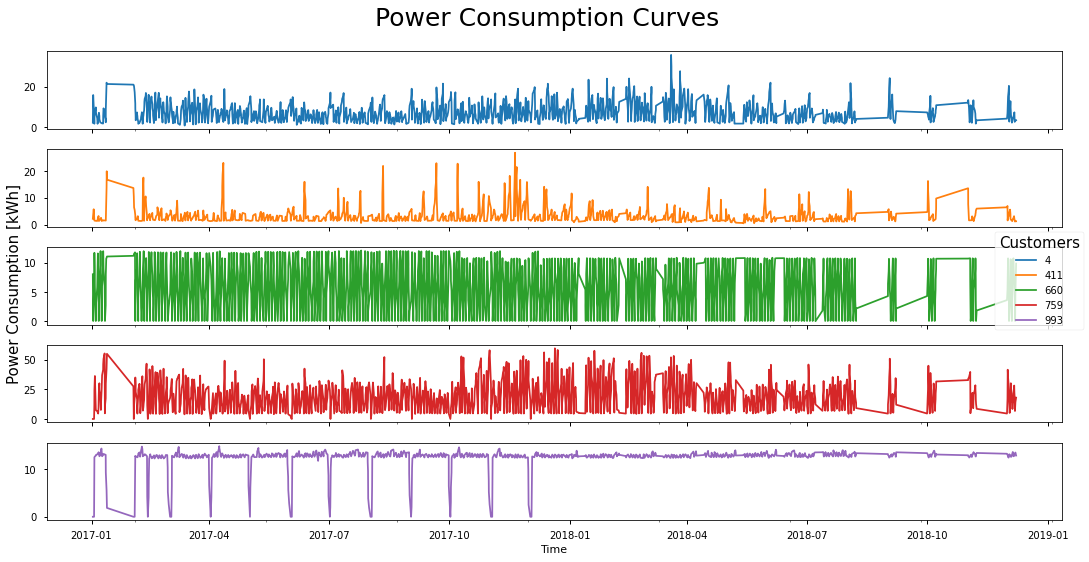

In [9]:
fig, axs = plt.subplots(5, 1, sharex=True, figsize=(15, 8))

anom_ts_data = []

for anom_ser in [660, 4, 411, 759, 993, 797, 518, 4][:5]:
    time_s, val_s = downsample(
        np.vstack((ts_series, time_series.iloc[anom_ser].values)).T, 500
    ).T

    anom_frame = pd.DataFrame(np.vstack((time_s, val_s)).T, columns=["Time", "value"])
    anom_frame["Label"] = anom_ser
    anom_frame["Time"] = pd.to_datetime(anom_frame["Time"] * 10 ** 9)
    anom_ts_data.append(anom_frame)

join_anom_ts = pd.concat(anom_ts_data).pivot(
    index="Time", columns="Label", values="value"
)

axs = join_anom_ts.interpolate().plot(subplots=True, legend=False, ax=axs)

hl = [ax.get_legend_handles_labels() for ax in axs]

handles = [x[0] for x, _ in hl]
labels = [y[0] for _, y in hl]

fig.legend(handles, labels, loc="center right", title="Customers")

fig.text(0.00, 0.5, "Power Consumption [kWh]", va="center", rotation="vertical")

fig.suptitle("Power Consumption Curves")

plt.tight_layout()

plt.savefig("../thesis/img/dataset-example.png")

plt.show()

## Seasonalities of Power Consupmtion Curve

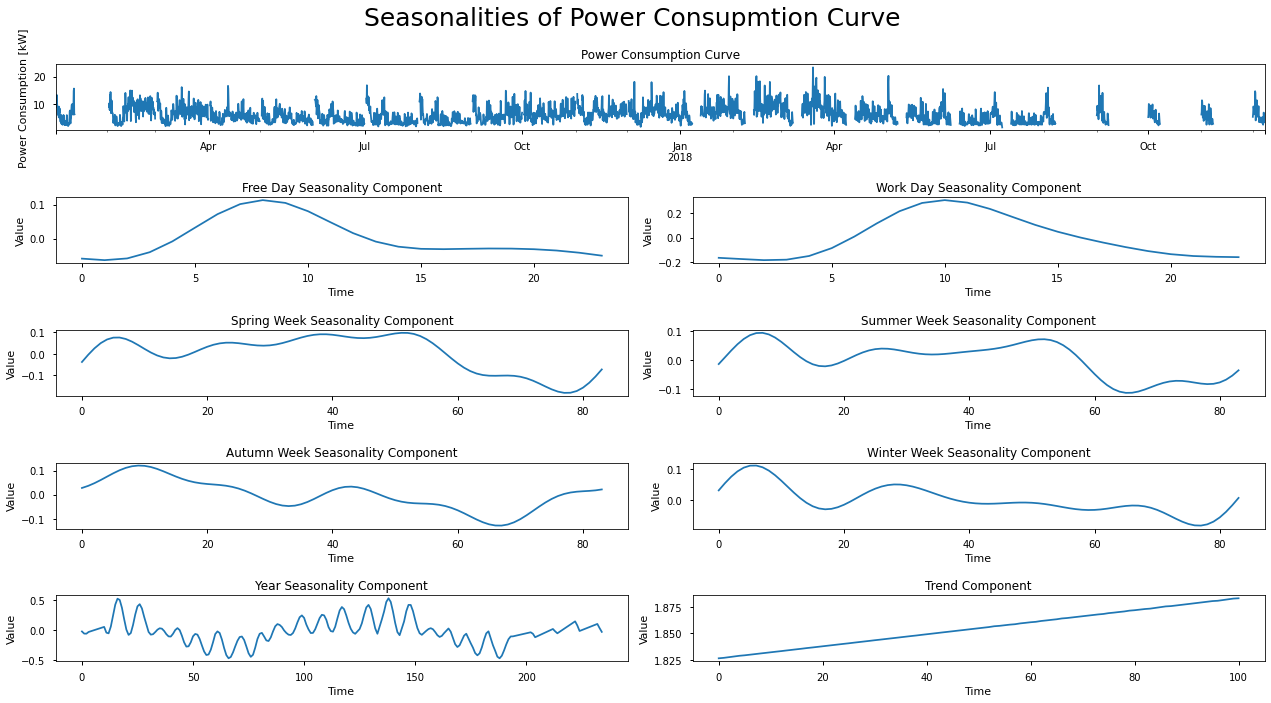

In [10]:
fig = plt.figure(figsize=(18, 10))
gs = fig.add_gridspec(5, 2)

ax1 = fig.add_subplot(gs[0, 0:])
axs = [fig.add_subplot(gs[int((i / 2)) + 1, i % 2]) for i in range(8)]

time_series.iloc[4].T.resample("4h").mean().plot(
    title="Power Consumption Curve",
    ylabel="Power Consumption [kW]",
    ax=ax1,
)

[
    x.iloc[4].plot(title=f"{name} Component", ylabel="Value", xlabel="Time", ax=ax)
    for name, x, ax in zip(
        (
            "Free Day Seasonality",
            "Work Day Seasonality",
            "Spring Week Seasonality",
            "Summer Week Seasonality",
            "Autumn Week Seasonality",
            "Winter Week Seasonality",
            "Year Seasonality",
            "Trend",
        ),
        (
            free_day,
            work_day,
            spring_week,
            summer_week,
            autumn_week,
            winter_week,
            year,
            trend,
        ),
        axs,
    )
]

fig.suptitle("Seasonalities of Power Consupmtion Curve")

plt.tight_layout()

plt.savefig("../thesis/img/seasonalities.png")

plt.show()